## The CIC-IoT-2023 Experiment!

In [1]:
import os
import vote
import pickle
import warnings
import functools
import numpy as np
import portion as P
import pandas as pd
from tqdm import tqdm
from collections import Counter
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from scipy.spatial.distance import cosine
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

In [2]:
repo_dir = "CIC-IoT-2023-Dataset"
if not os.path.exists(repo_dir):
    !git clone https://github.com/val-co/CIC-IoT-2023-Dataset.git

DATASET_DIRECTORY = '/home/ubuntu/IDS/CIC-IoT-2023-Dataset/'

In [3]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
dataset = df_sets[:int(len(df_sets)*.1)]
print(dataset)

['part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv']


In [4]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count',
       'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
       'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
       'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
       'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

scaler = MinMaxScaler()

for data in tqdm(dataset):
    scaler.fit(pd.read_csv(DATASET_DIRECTORY + data)[X_columns])

100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


In [5]:
dict_2classes = {
    'DDoS-RSTFINFlood': 1,
    'DDoS-PSHACK_Flood': 1,
    'DDoS-SYN_Flood': 1,
    'DDoS-UDP_Flood': 1,
    'DDoS-TCP_Flood': 1,
    'DDoS-ICMP_Flood': 1,
    'DDoS-SynonymousIP_Flood': 1,
    'DDoS-ACK_Fragmentation': 1,
    'DDoS-UDP_Fragmentation': 1,
    'DDoS-ICMP_Fragmentation': 1,
    'DDoS-SlowLoris': 1,
    'DDoS-HTTP_Flood': 1,
    'DoS-UDP_Flood': 1,
    'DoS-SYN_Flood': 1,
    'DoS-TCP_Flood': 1,
    'DoS-HTTP_Flood': 1,
    'Mirai-greeth_flood': 1,
    'Mirai-greip_flood': 1,
    'Mirai-udpplain': 1,
    'Recon-PingSweep': 1,
    'Recon-OSScan': 1,
    'Recon-PortScan': 1,
    'VulnerabilityScan': 1,
    'Recon-HostDiscovery': 1,
    'DNS_Spoofing': 1,
    'MITM-ArpSpoofing': 1,
    'BenignTraffic': 0,
    'BrowserHijacking': 1,
    'Backdoor_Malware': 1,
    'XSS': 1,
    'Uploading_Attack': 1,
    'SqlInjection': 1,
    'CommandInjection': 1,
    'DictionaryBruteForce': 1
}

In [6]:
X_ = []
y_ = []

for data in tqdm(dataset):
    d = pd.read_csv(DATASET_DIRECTORY + data)
    d[X_columns] = scaler.transform(d[X_columns])
    new_y = [dict_2classes[k] for k in d[y_column]]
    d[y_column] = new_y
    X_.append(d[X_columns])
    y_.append(d[y_column])
    del d

X = pd.concat(X_)
y = pd.concat(y_)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


In [7]:
# Split the data into training (60%), validation (30%), and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Display the shapes of the resulting sets
print("Train set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)
print("Test set shape:", X_test.shape)

Train set shape: (143212, 46)
Validation set shape: (71606, 46)
Test set shape: (23869, 46)


In [8]:
model1 = XGBClassifier(n_estimators=25, n_jobs=8, max_depth=5, random_state=42)
print("Models Training")
model1.fit(X_train, y_train)
print("Models Trained")

Models Training
Models Trained


In [9]:
import time
from math import sqrt

def mcc(tp, fp, tn, fn):
    x = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return ((tp * tn) - (fp * fn)) / sqrt(x)

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef

y_pred = model1.predict(X_test)
    
print("\nModel Metrics")
print('accuracy_score: {:.3f}'.format(accuracy_score(y_pred, y_test)))
print('recall_score: {:.3f}'.format(recall_score(y_pred, y_test)))
print('precision_score: {:.3f}'.format(precision_score(y_pred, y_test)))
print('f1_score: {:.3f}'.format(f1_score(y_pred, y_test)))

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, y_pred)

# Extract values from the confusion matrix
TP = confusion_matrix_result[1, 1]  
FP = confusion_matrix_result[0, 1]  
FN = confusion_matrix_result[1, 0]  
TN = confusion_matrix_result[0, 0] 

# Print the rates
print("\nConfusion Matrix")
print("True Positive Rate (Sensitivity): {:.3f}".format(TP / (TP + FN))) 
print("True Negative Rate (Specificity): {:.3f}".format(TN / (FP + TN))) 
print("False Positive Rate (Type I Error): {:.3f}".format(FP / (FP + TN))) 
print("False Negative Rate (Type II Error): {:.3f}".format(FN / (TP + FN)), "\n") 
print("Matthews Corelation Coefficient: {:.3f}".format(mcc(TP, FP, TN, FN)))
print("AUC:", roc_auc_score(y_pred, y_test))


Model Metrics
accuracy_score: 0.996
recall_score: 0.998
precision_score: 0.997
f1_score: 0.998

Confusion Matrix
True Positive Rate (Sensitivity): 0.997
True Negative Rate (Specificity): 0.929
False Positive Rate (Type I Error): 0.071
False Negative Rate (Type II Error): 0.003 

Matthews Corelation Coefficient: 0.909
AUC: 0.9466454915209743


In [ ]:
print("Verifying IDS")

X_test_nr = []
y_test_nr = []

def label_checker(expected, mapping):
    return vote.mapping_check_argmax(mapping, expected)

e = vote.Ensemble.from_xgboost(model1)
delta = 0.001 # 0.1% perturbations, very stealthy
passe = 0

for i in tqdm(range(len(X_test))):
    xvec = X_test.iloc[i].values
    label = y_test.iloc[i]
    if model1.predict([np.asarray(xvec)]) != label: # Don't bother with samples that were misclassified
        continue
    domain = [(max(0.0, x-delta), min(1.0, x+delta)) for x in xvec]
    checker = functools.partial(label_checker, label)
    passed = e.absref(checker, domain)
    if not passed:
        X_test_nr.append(xvec)
        y_test_nr.append(label)
    else:
        passe += 1 
        
print('IDS Robustness: {:.3f}'.format(passe/len(X_test)))

Verifying IDS


100%|██████████| 23869/23869 [00:20<00:00, 1187.74it/s]

IDS Robustness: 0.967


In [ ]:
adversarial_examples = []
adversarial_labels = []
true_labels = []
delta = 0.001 # 0.01% perturbations, very stealthy
multiplier = 32

e = vote.Ensemble.from_xgboost(model1)

for xvec, label in zip(X_test_nr, y_test_nr):  
    
    def check_robustness(m):
        o = vote.mapping_check_argmax(m, label)
        if o == vote.FAIL: 
            if label==0:
                for i in range(multiplier): 
                    np.random.seed(42+i)
                    center = [np.random.uniform(low=m.inputs[dim].lower, high=m.inputs[dim].upper) for dim in range(m.nb_inputs)]
                    try:
                        assert(model1.predict([center]) != label)
                        adversarial_examples.append(center)
                        true_labels.append(label)
                        adversarial_labels.append(abs(1-label))
                    except AssertionError as e:
                        pass
            if label==1:
                for i in range(3*multiplier): 
                    np.random.seed(42+i)
                    center = [np.random.uniform(low=m.inputs[dim].lower, high=m.inputs[dim].upper) for dim in range(m.nb_inputs)]
                    try:
                        assert(model1.predict([center]) != label)
                        adversarial_examples.append(center)
                        true_labels.append(label)
                        adversarial_labels.append(abs(1-label))
                    except AssertionError as e:
                        pass
        return o
        
    
    input_region = [(max(x - delta, 0.0), min(1.0, x + delta)) for x in xvec]     
    e.absref(check_robustness, input_region)
    
print("Adversarial Examples: ", Counter(true_labels))

Adversarial Examples:  Counter({0: 11520, 1: 11227})


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

y_pred = model1.predict(adversarial_examples)
    
print("\nModel Metrics")
print('accuracy_score: {:.3f}'.format(accuracy_score(y_pred, true_labels)))
print('recall_score: {:.3f}'.format(recall_score(y_pred, true_labels)))
print('precision_score: {:.3f}'.format(precision_score(y_pred, true_labels)))
print('f1_score: {:.3f}'.format(f1_score(y_pred, true_labels)))

# Calculate the confusion matrix
confusion_matrix_result = confusion_matrix(true_labels, y_pred)

# Extract values from the confusion matrix
TP = confusion_matrix_result[1, 1]  
FP = confusion_matrix_result[0, 1]  
FN = confusion_matrix_result[1, 0]  
TN = confusion_matrix_result[0, 0] 

# Print the rates
print("\nConfusion Matrix")
print("True Positive Rate (Sensitivity): {:.3f}".format(TP / (TP + FN))) 
print("True Negative Rate (Specificity): {:.3f}".format(TN / (FP + TN))) 
print("False Positive Rate (Type I Error): {:.3f}".format(FP / (FP + TN))) 
print("False Negative Rate (Type II Error): {:.3f}".format(FN / (TP + FN)), "\n") 
print("Matthews Corelation Coefficient: {:.3f}".format(mcc(TP, FP, TN, FN)))


Model Metrics
accuracy_score: 0.000
recall_score: 0.000
precision_score: 0.000
f1_score: 0.000

Confusion Matrix
True Positive Rate (Sensitivity): 0.000
True Negative Rate (Specificity): 0.000
False Positive Rate (Type I Error): 1.000
False Negative Rate (Type II Error): 1.000 

Matthews Corelation Coefficient: -1.000


In [ ]:
import pickle

with open('combined_intervals_0.pkl', 'rb') as f3:
    combined_intervals_0 = pickle.load(f3)
    
with open('combined_intervals_1.pkl', 'rb') as f4:
    combined_intervals_1 = pickle.load(f4)    

In [ ]:
from sklearn.inspection import permutation_importance

perm_set = np.concatenate((X_train, X_valid))
perm_lab = np.concatenate((y_train, y_valid))

perm_importance = permutation_importance(model1, perm_set, perm_lab, random_state=12345, n_repeats=5, n_jobs=-1)
wv = perm_importance['importances_mean']

In [ ]:
def distance(samples):
    distances = []
    preds = model1.predict(np.asarray(samples))
    for sample, pred in zip(np.asarray(samples), preds):
        if pred == 1:
            distances.append(np.sum(wv * [sample[i] in combined_intervals_0[i] for i in range(e.nb_inputs)]))
        else:
            distances.append(np.sum(wv * [sample[i] in combined_intervals_1[i] for i in range(e.nb_inputs)]))
    return distances

In [ ]:
distances_X_test  = distance(X_test)
distances_adversarial_examples = distance(adversarial_examples)

In [ ]:
test_set = np.concatenate((X_test, adversarial_examples))
test_lab_sym = np.concatenate((np.zeros(len(y_test), dtype=bool), np.ones(len(true_labels), dtype=bool)))

test_lab = np.concatenate((y_test, true_labels))

print("Evaluation Samples:", len(test_set))

Evaluation Samples: 46616


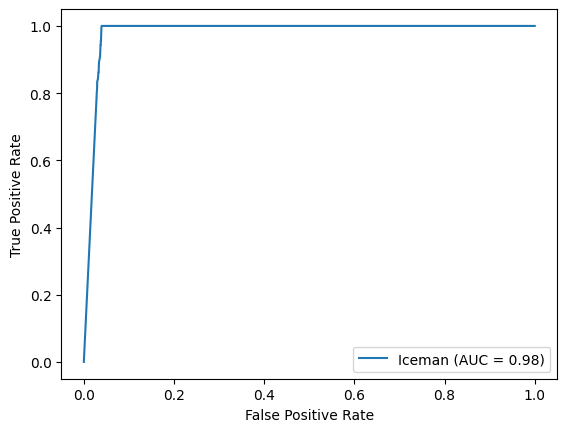

0.024


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix

S = np.concatenate((distances_X_test, distances_adversarial_examples))

fpr, tpr, thresholds = roc_curve(test_lab_sym, S, drop_intermediate = False)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Iceman')
display.plot()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
threshold = round(thresholds[optimal_idx], 3)
print(threshold)

## Then we evaluate using Iceman! 

In [ ]:
def IDS(x, threshold):
    S = distance(x)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            predictions.append(pred)
        else:
            predictions.append(abs(1-pred))
    return predictions

In [ ]:
y_pred = IDS(test_set, threshold)

In [ ]:
fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
roc_auc = auc(fpr, tpr)
print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc, 3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  0.982 
F1-Score:  0.988 
MCC:  0.953
Rec:  0.985 
Prec:  0.991 
AUC:  0.982
True Positive Rate (TPR): 0.991
True Negative Rate (TNR): 0.957
False Positive Rate (FPR): 0.043
False Negative Rate (FNR): 0.009


## Alert Management Stuff!

In [ ]:
true_positives = X_test[y_test == 1] # True Attack. Investigate!
true_negatives = X_test[y_test == 0] # True Benign. Do Nothing!
false_positives = [example for example, label in zip(adversarial_examples, true_labels) if label == 0] # Evasion (true_label = benign, pred = attack). Caution!
false_negatives = [example for example, label in zip(adversarial_examples, true_labels) if label == 1] # Evasion (true_label = attack, pred = benign). Investigate!

exp_newset = np.concatenate((true_positives, true_negatives, false_positives, false_negatives))
exp_newlab = np.concatenate((np.full(len(true_positives), 1), np.full(len(true_negatives), 0), np.full(len(false_positives), 3), np.full(len(false_negatives), 2)))

In [ ]:
def IDS_alert(x, threshold, filter = False):
    S = distance(x)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            if pred == 1:
                predictions.append('tp' if filter else 1) # TP
            else:
                predictions.append('tn' if filter else 0) # TN
        else:
            if pred == 1:
                predictions.append('fp' if filter else 3) # FP
            else:
                predictions.append('fn' if filter else 2) # FN
    return predictions

In [ ]:
from sklearn.metrics import classification_report

y_pred = IDS_alert(exp_newset, threshold)

# Print classification report
print(classification_report(exp_newlab, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       560
           1       1.00      0.98      0.99     23309
           2       0.95      1.00      0.97     11227
           3       0.97      1.00      0.98     11520

    accuracy                           0.98     46616
   macro avg       0.73      0.75      0.74     46616
weighted avg       0.97      0.98      0.97     46616



In [ ]:
exp_newlab_filter = np.concatenate((np.full(len(true_positives), 'tp'), np.full(len(true_negatives), 'tn'), np.full(len(false_positives), 'fp'), np.full(len(false_negatives), 'fn')))

y_pred = IDS_alert(exp_newset, threshold, filter=True)

# Print classification report
print(classification_report(exp_newlab_filter, y_pred))

              precision    recall  f1-score   support

          fn       0.95      1.00      0.97     11227
          fp       0.97      1.00      0.98     11520
          tn       0.00      0.00      0.00       560
          tp       1.00      0.98      0.99     23309

    accuracy                           0.98     46616
   macro avg       0.73      0.75      0.74     46616
weighted avg       0.97      0.98      0.97     46616



## Now we evaluate performance using VERITAS!

In [ ]:
import veritas

def veritas_attack(model, samples, labels, epsilon, timeout=1, search_steps=100, verbose=False):
    adversarial_examples, true_labels = [], []
    assert len(np.unique(np.asarray(y_test))), "Input must be a binary-classification problem with labels 0/1"
    assert np.min(X_test_nr)>=0 and np.max(X_test_nr)<=1.0, "Input Dataset must be Min-Max Normalised"
    at = veritas.get_addtree(model)
    print("\nFinding Adversarial Examples using Veritas:")
    for i in tqdm(range(len(labels))):
        base_example = samples[i]
        true_label = labels[i]
        if model.predict([base_example]) != true_label:
            if verbose:
                print(i, "Skipping Misclassified Sample","\n")
            continue
        heur = veritas.HeuristicType.MAX_OUTPUT if true_label == 0 else veritas.HeuristicType.MIN_OUTPUT
        config = veritas.Config(heur)
        config.ignore_state_when_worse_than = 0.0
        prune_box = [veritas.Interval(max(0.0, x-epsilon), min(1.0, x+epsilon)) for x in base_example]
        search = config.get_search(at, prune_box)
        stop_reason = search.step_for(timeout, search_steps) 
        while search.num_solutions() == 0:
            if search.steps(search_steps) == veritas.StopReason.NO_MORE_OPEN or stop_reason:
                if verbose:
                    print(i, "Timeout & Skipped","\n") 
                break
        if search.num_solutions() > 0:
            sol = search.get_solution(0)
            adv_example = veritas.get_closest_example(sol, base_example, eps=1e-3)
            predicted_label = int(model.predict([adv_example]))
            l_inf = np.max(np.abs(base_example - adv_example))
            if int(predicted_label) != int(true_label) and l_inf < epsilon:
                adversarial_examples.append(adv_example)
                true_labels.append(true_label)
                if verbose:
                    print(i, "True Label:", str(true_label), "--> Adversarial Label:", str(predicted_label), "L-inf:", l_inf, "\n")
            else:
                if verbose:
                    print(i, "Debugging Needed","\n") 
        else:
            if verbose:
                pass
                print(i, "No Adversarial Example Found","\n")
    print("\nFound:", len(adversarial_examples), "| Split:", Counter(true_labels))
    return adversarial_examples, true_labels

In [ ]:
adversarial_examples, true_labels = veritas_attack(model1, np.asarray(X_test_nr), np.asarray(y_test_nr), delta, 2, 10000)


| XGBOOST's base_score
|   base_score diff std      3.8628626708685837e-07 OK
|   base_score reported      0.87058634
|   versus manually detected 1.9061529452431132
|   abs err                  1.0355666052431132
|   rel err                  1.1895047712822064
|   (!) base_score NOT THE SAME with relative tolerance 0.00025


Finding Adversarial Examples using Veritas:


100%|██████████| 690/690 [00:10<00:00, 64.77it/s] 



Found: 0 | Split: Counter()


Apparently, VERITAS could not find any adversarial examples! 

## Then we evaluate using GROOT!

In [ ]:
from groot.model import GrootRandomForestClassifier
forest = GrootRandomForestClassifier(n_estimators=25, max_depth=5, attack_model = [delta] * X_train.shape[1], random_state=42, verbose=True, n_jobs=10)

forest.fit(np.asarray(X_train), np.asarray(y_train))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  25 out of  25 | elapsed:   17.9s finished


GrootRandomForestClassifier(attack_model=[0.001, 0.001, 0.001, 0.001, 0.001,
                                          0.001, 0.001, 0.001, 0.001, 0.001,
                                          0.001, 0.001, 0.001, 0.001, 0.001,
                                          0.001, 0.001, 0.001, 0.001, 0.001,
                                          0.001, 0.001, 0.001, 0.001, 0.001,
                                          0.001, 0.001, 0.001, 0.001, 0.001, ...],
                            max_depth=5, n_estimators=25, n_jobs=10,
                            random_state=42, verbose=True)

In [ ]:
y_pred = forest.predict(test_set)

In [ ]:
from sklearn.metrics import roc_auc_score

print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc_score(y_pred, test_lab), 3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  0.846 
F1-Score:  0.889 
MCC:  0.659
Rec:  0.955 
Prec:  0.832 
AUC:  0.802
True Positive Rate (TPR): 0.832
True Negative Rate (TNR): 0.888
False Positive Rate (FPR): 0.112
False Negative Rate (FNR): 0.168


## Then we evaluate using OC-Score!

In [ ]:
ytrain_pred = model1.predict(X_train) # For the Reference Set
acc_train = accuracy_score(y_train, ytrain_pred)
print(f"Training Accuracy: {acc_train:.3f}")

Training Accuracy: 0.997


In [ ]:
# Find a reference set, e.g. set of correctly classified training examples
xref_mask = ytrain_pred == y_train
xref = X_train[xref_mask]
dtype = np.uint16
idref_train = model1.apply(xref).astype(dtype)

In [ ]:
exp_df = pd.DataFrame(test_set, columns=X_test.columns)
idref_exp = model1.apply(exp_df).astype(dtype)

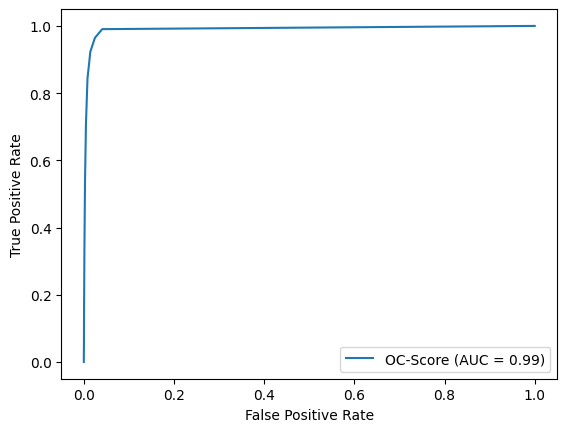

1


In [ ]:
import ocscore

S = ocscore.ocscores(idref_train, idref_exp)

fpr, tpr, thresholds = roc_curve(test_lab_sym, S, drop_intermediate = False)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='OC-Score')
display.plot()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
threshold = round(thresholds[optimal_idx], 3)
print(threshold)


In [ ]:
def OC_predict(x, refset, threshold):
    x = pd.DataFrame(x, columns=X_test.columns)
    testset = model1.apply(x).astype(dtype)
    S = ocscore.ocscores(refset, testset)
    predictions, preds = [], model1.predict(np.asarray(x))
    for score, pred in zip(S, preds):
        if score <= threshold:
            predictions.append(pred)
        else:
            predictions.append(abs(1-pred))
    return predictions

In [ ]:
y_pred = OC_predict(test_set, idref_train, threshold)

In [ ]:
fpr, tpr, thresholds = roc_curve(test_lab_sym, S)
roc_auc = auc(fpr, tpr)
print("Acc: ", round(accuracy_score(y_pred, test_lab), 3), "\nF1-Score: ", round(f1_score(y_pred, test_lab), 3), "\nMCC: ", round(matthews_corrcoef(y_pred, test_lab),3))
print("Rec: ", round(recall_score(y_pred, test_lab), 3), "\nPrec: ", round(precision_score(y_pred, test_lab), 3), "\nAUC: ", round(roc_auc, 3))
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_lab, y_pred).ravel()
# Calculate rates
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (fn + tp)  # False Negative Rate
# Print rates
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Acc:  0.971 
F1-Score:  0.98 
MCC:  0.926
Rec:  0.99 
Prec:  0.97 
AUC:  0.99
True Positive Rate (TPR): 0.970
True Negative Rate (TNR): 0.973
False Positive Rate (FPR): 0.027
False Negative Rate (FNR): 0.030


## Timing Experiments!

In [ ]:
runs = 100

In [ ]:
times_2_iceman = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = IDS(test_set, threshold=0.4997)
    times_2_iceman.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_2_iceman.pkl', 'wb') as f:
    pickle.dump(times_2_iceman, f)
print("Complete!")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [11:20<00:00,  6.81s/it]

Complete!


In [ ]:
times_2_groot = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = forest.predict(test_set)
    times_2_groot.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_2_groot.pkl', 'wb') as f:
    pickle.dump(times_2_groot, f)
print("Complete!")

100%|██████████| 100/100 [00:10<00:00,  9.42it/s]

Complete!


In [ ]:
times_2_ocscore = []

for _ in tqdm(range(runs)):
    time_output = %timeit -o -n 1 -r 1 -q y_pred = OC_predict(test_set, idref_train, threshold)
    times_2_ocscore.append(time_output.average)

with open('/home/ubuntu/IDS/times/times_2_ocscore.pkl', 'wb') as f:
    pickle.dump(times_2_ocscore, f)
print("Complete!")

Complete!
